In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Principal Component Analysis

The below algorithm is not useful for practical implementation on large data, due to its $O(np^2)$ time complexity. However, this is the simplest one I found, which comes from the wikipedia article found [here](https://en.wikipedia.org/wiki/Covariance).

Steps:

1. Organize the data into a matrix X, such that each data point is a $1\times p$ row vector inside the $n\times p$ matrix X.
2. Find the emprical mean of each element and store it in a vector $u$. Subtract this vector fom each row vector of X, and store it in a new matrix B.
3. Find the $n\times n$ covariance matrix of B, which will be called C. Do this via the following formula: $C = \frac{1}{n - 1}B^*B$, such that $B^*$ is the conjugate transpose of B.
4. Find the eigenvalues and eigenvectors of the covariance matrix C.
    - Eigenvalues are the variance accounted for by the component
    - Eigenvectors are the unit vector corresponding to the component

In [ ]:
def myPCA(X):

    n = X.shape[0]
    p = X.shape[1]

    # center the data about the mean
    means = np.average(X, 0)
    B = X - means

    # calculate the covariance matrix
    C = 1/(n - 1) * B.T @ B

    # calculate the eigenvalues
    vals, vecs = np.linalg.eig(C)

    # sort the eigenvectors by eigenvalue
    variances = np.abs(vals)
    sorted_indices = np.flip(np.argsort(variances))
    sorted_vals = variances[sorted_indices]
    sorted_vecs = vecs[sorted_indices]

    # return values
    return {'values':sorted_vals, 'components':sorted_vecs, 'C':C}

# PCA as a controllability test

For the purposes of this lab, the sole types of systems that we need to be concerned about are those taking the from $\dot{x}=f(u)$, where $x \in \mathbb{R}^n$ is the fully observable state of the system, $f: \mathbb{R}^m → \mathbb{R}^n$ is some arbitrary function, and $u \in \mathbb{R}^m$ is some control input. Since $f$ has no dependence on state, the tests for controllability become a simple rank calculation and require no knowledge of the underlying structure of $f$.

Since $f$ has no dependence on x, we can directly compute the following integral from the definition of $\dot{x}$.

$$ x(t) = ∫_{0}^{\tau}f(u(\tau))dτ $$

Now suppose that $u(\tau) = u_1$ is constant along some time interval between $t = a$ and $t = b$. It follows trivially that $Δx = (b - a)f(u_1)$. If $u(\tau)$ were to suddenly change to another value $u_2$ immediately afterwards, it follows that the resulting value of $Δx$ would be a linear combination of the values $f(u_1)$ and $f(u_2)$. Therefore, it is trivial to show that the reachable space of $\Delta x$ is the $span\{f(u) |\forall u \in \mathbb{R}^m \}$ for any linear combination with positive constants.

In our context the model $f$ itself is not easily expressible in a concise analytical manner. As a result, it is far simpler to instead perform the calculations in a data-driven manner. As will be expressed later, this alteration of perspective will also permit resilience against noise.

## Data-driven techniques

Suppose we have a set of column vectors $f(u)$ that fulfill the above criteria. We will denote the matrix $[f(u_1), f(u_2), ... f(u_k)]$ as $F$, or the matrix containing every output from the model $f$. In an ideal environment with no noise the test is simply checking to see if the centered $f$ is of full row rank. In other words, the ideal algorithm is as follows:
$$rank(f - avg(f)) = n$$
If it is, it follows that the span of all of the vectors that are known to be an output of $f$ is of the correct dimensionality, meaning that every point is accessible. In contrast, if it is not that implies that there is not enough information to conclusively prove $f$ is controllable. See examples 1 and 2 below for evidence of the former and prior respectively. Each of them show the same function $f$ with different control inputs. Example 1 has a complex enough input to determine controllability, but Example 2 does not.

In [ ]:
# setup
def f(uvec):
    (u, v) = uvec

    return np.array([
        u,
        v
    ])
 # example 1
def u1(t):
    return np.array([
        np.sin(t),
        t
    ])

n = 1000
t = np.linspace(0,10,n)
original_vals = np.empty((n, 2))
for indx, time in enumerate(t):
    original_vals[indx, :] = f(u1(time))

vals = original_vals - np.average(original_vals, 0)
rank = np.linalg.matrix_rank(vals)
if rank == 2:
    print("The system \033[92mis\033[00m controllable")
else:
    print("The system \033[91mis not\033[00m controllable")

The system is controllable


In [ ]:
# example 2
def u2(t):
    return np.array([
        np.sin(t),
        1
    ])

n = 1000
t = np.linspace(0,10,n)
original_vals = np.empty((n, 2))
for indx, time in enumerate(t):
    original_vals[indx, :] = f(u2(time))

vals = original_vals - np.average(original_vals, 0)
rank = np.linalg.matrix_rank(vals)
if rank == 2:
    print("The system \033[92mis\033[00m controllable")
else:
    print("The system \033[91mis not\033[00m controllable")

The system is not controllable


## Accounting for noise

This simplistic model degrades once noise is introduced into the system. Matrix rank is independent of the scale of the nonzero bases, so one axis with a  small amount of noise-induced variance would be equivalently important to another axis with a large amount of input-induced variance. Evidence of this is shown below in Example 3.

In [ ]:
# example 3
def f2(uvec):

    (u, v) = uvec

    return np.array([
        u,
        0.01 * np.random.rand()
    ])

def u3(t):
    return np.array([
        np.sin(t),
        t
    ])

n = 1000
t = np.linspace(0,10,n)
original_vals = np.empty((n, 2))
for indx, time in enumerate(t):
    original_vals[indx, :] = f2(u3(time))

vals = original_vals - np.average(original_vals, 0)
rank = np.linalg.matrix_rank(vals)
if rank == 2:
    print("The system \033[92mis\033[00m controllable")
else:
    print("The system \033[91mis not\033[00m controllable")

The system is controllable


The inputs are the same as the controllable case, but now we have some noise in the trivialy uncontrollable model $f$ itself. When plotting the values of f over time this becomes much more apparent.

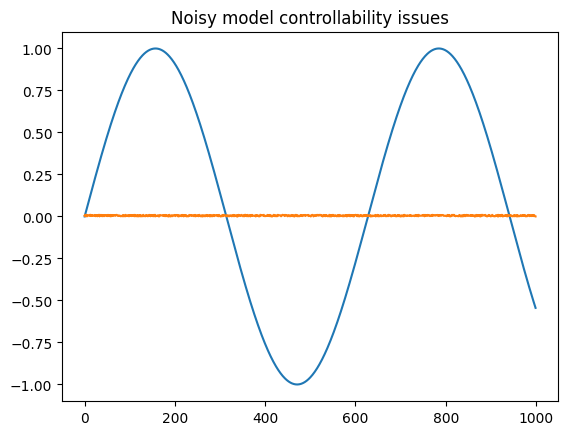

In [ ]:
plt.plot(original_vals)
plt.title("Noisy model controllability issues")
plt.show()

This model clearly does not demonstrate controllable behavior in each axis, but this data-driven approach is not robust enough to detect this erroneous behavior. To deal with this effect, we will make use of the Principal Component Analysis technique.

In [ ]:
# example 3
def f2(uvec):

    (u, v) = uvec

    return np.array([
        u,
        0.01 * np.random.rand()
    ])

def u3(t):
    return np.array([
        np.sin(t),
        t
    ])

n = 1000
t = np.linspace(0,10,n)
original_vals = np.empty((n, 2))
for indx, time in enumerate(t):
    original_vals[indx, :] = f2(u3(time))

threshold = 0.01
results = myPCA(original_vals)
vars = results['values']

# printing about not normalized axes
print("Variances: ", end="")
count = 0
for indx, var in enumerate(vars):
    if var/np.max(vars) < threshold:
        color = "\033[91m"
        count += 1
    else:
        color = "\033[92m"
    if indx == len(vars) - 1:
        last = "\n"
    else:
        last = ", "
    print(f"{color}{var:.6f}\033[00m", end=last)

# printing about normalized axes
print("Normalized Variances: ", end="")
for indx, nvar in enumerate(vars/np.max(vars)):
    if nvar < threshold:
        color = "\033[91m"
    else:
        color = "\033[92m"
    if indx == len(vars) - 1:
        last = "\n"
    else:
        last = ", "
    print(f"{color}{nvar:.6f}\033[00m", end=last)

# printing about controllability results
print("\n")
if count == 0:
    print("This test found the system to be \033[92mcontrollable\033[00m")
elif count == 1:
    print(f"This test found the system to be \033[91muncontrollable\033[00m with 1 problematic axis")
else:
    print(f"This test found the system to be \033[91muncontrollable\033[00m with {count} problematic axes")

Variances: 0.443638, 0.000008
Normalized Variances: 1.000000, 0.000018


This test found the system to be uncontrollable with 1 problematic axis


The above code performs PCA on the data and finds each principal axis. From there it checks if the variance along that axis is above some predefined threshold relative to the maximum variance. If it falls below the permitted value then it is considered to be based in noise and therefore an indicator of uncontrollability.

A threshold is used because the variance would practically never reach zero. Furthermore, the normalized variance is used in determining the threshold because it provides more restrictions on the geometry of the distribution and ensures that the cutoffs are taken relative to a given reference frame. This *could* be subject to change if we get a better idea of the variance induced by sensor noise, but as of right now it seems to be effective.

When the same PCA is used on a controllable system with controllable inputs it can successfully identify its controllable nature.

In [ ]:
# example 4
def u4(t):
    return np.array([
        2 * np.sin(t),
        t/2
    ])

def f(u):
    return np.array([
        u[0],
        0
    ])

n = 1000
t = np.linspace(0,10,n)
original_vals = np.empty((n, 2))
for indx, time in enumerate(t):
    original_vals[indx, :] = f(u4(time)) + np.random.rand(2) * 0.01

threshold = 0.01
results = myPCA(original_vals)
vars = results['values']

# printing about not normalized axes
print("Variances: ", end="")
count = 0
for indx, var in enumerate(vars):
    if var/np.max(vars) < threshold:
        color = "\033[91m"
        count += 1
    else:
        color = "\033[92m"
    if indx == len(vars) - 1:
        last = "\n"
    else:
        last = ", "
    print(f"{color}{var:.6f}\033[00m", end=last)

# printing about normalized axes
print("Normalized Variances: ", end="")
for indx, nvar in enumerate(vars/np.max(vars)):
    if nvar < threshold:
        color = "\033[91m"
    else:
        color = "\033[92m"
    if indx == len(vars) - 1:
        last = "\n"
    else:
        last = ", "
    print(f"{color}{nvar:.6f}\033[00m", end=last)

# printing about controllability results
print("\n")
if count == 0:
    print("This test found the system to be \033[92mcontrollable\033[00m")
elif count == 1:
    print(f"This test found the system to be \033[91muncontrollable\033[00m with 1 problematic axis")
else:
    print(f"This test found the system to be \033[91muncontrollable\033[00m with {count} problematic axes")

Variances: 1.774499, 0.000008
Normalized Variances: 1.000000, 0.000005


This test found the system to be uncontrollable with 1 problematic axis


In [ ]:
results

{'values': array([1.77449926e+00, 8.35137427e-06]),
 'components': array([[ 9.99999999e-01,  3.35147847e-05],
        [-3.35147847e-05,  9.99999999e-01]]),
 'C': array([[ 1.77449926e+00, -5.94716806e-05],
        [-5.94716806e-05,  8.35336745e-06]])}

This technique is useful in determining the relative importance of each axis. As a result, when using it one should make sure that each element of $f$ should be of roughly equivalent importance. Significant deviations in importance can cause confusion between noise and intentional inputs.

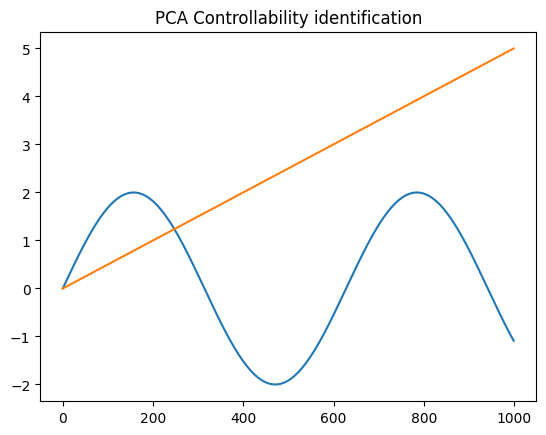

In [ ]:
plt.plot(original_vals)
plt.title("PCA Controllability identification")
plt.show()

One important note is that the PCA does not care about the values of $u(t)$. As a result, the underlying dynamics of $f(u)$ are irrelevant, as it is assumed that any values of $u(t)$ can be chosen and therefore any desired value of $\dot{x}$.

In [ ]:
# example 4
def u4(t):
    return np.array([
        t,
        np.cos(t + 3)
    ])

# setup
def f_paper(uvec):
    (u, v) = uvec

    return np.array([
        np.sin(u),
        v
    ])

n = 1000
t = np.linspace(0,10,n)
original_vals = np.empty((n, 2))
for indx, time in enumerate(t):
    original_vals[indx, :] = f_paper(u4(time))

threshold = 0.01
results = myPCA(original_vals)
vars = results['values']

# printing about not normalized axes
print("Variances: ", end="")
count = 0
for indx, var in enumerate(vars):
    if var/np.max(vars) < threshold:
        color = "\033[91m"
        count += 1
    else:
        color = "\033[92m"
    if indx == len(vars) - 1:
        last = "\n"
    else:
        last = ", "
    print(f"{color}{var:.6f}\033[00m", end=last)

# printing about normalized axes
print("Normalized Variances: ", end="")
for indx, nvar in enumerate(vars/np.max(vars)):
    if nvar < threshold:
        color = "\033[91m"
    else:
        color = "\033[92m"
    if indx == len(vars) - 1:
        last = "\n"
    else:
        last = ", "
    print(f"{color}{nvar:.6f}\033[00m", end=last)

# printing about controllability results
print("\n")
if count == 0:
    print("This test found the system to be \033[92mcontrollable\033[00m")
elif count == 1:
    print(f"This test found the system to be \033[91muncontrollable\033[00m with 1 problematic axis")
else:
    print(f"This test found the system to be \033[91muncontrollable\033[00m with {count} problematic axes")

Variances: 0.581512, 0.388301
Normalized Variances: 1.000000, 0.667743


This test found the system to be controllable


In [ ]:
results

{'values': array([0.58151233, 0.38830103]),
 'components': array([[-0.53516853, -0.84474531],
        [-0.84474531,  0.53516853]]),
 'C': array([[ 0.44363778, -0.08734718],
        [-0.08734718,  0.52617557]])}

In [ ]:
# example 4
def u4(t):
    return np.array([
        t,
        np.cos(t + 3)
    ])

# setup
def f_paper(uvec):
    (u, v) = uvec

    return np.array([
        np.sin(u),
        v
    ])

n = 1000
t = np.linspace(0,10,n)
original_vals = np.empty((n, 2))
for indx, time in enumerate(t):
    original_vals[indx, :] = f_paper(u4(time) + 0.01 * np.random.rand(2))

threshold = 0.01
results = myPCA(original_vals)
vars = results['values']

# printing about not normalized axes
print("Variances: ", end="")
count = 0
for indx, var in enumerate(vars):
    if var/np.max(vars) < threshold:
        color = "\033[91m"
        count += 1
    else:
        color = "\033[92m"
    if indx == len(vars) - 1:
        last = "\n"
    else:
        last = ", "
    print(f"{color}{var:.6f}\033[00m", end=last)

# printing about normalized axes
print("Normalized Variances: ", end="")
for indx, nvar in enumerate(vars/np.max(vars)):
    if nvar < threshold:
        color = "\033[91m"
    else:
        color = "\033[92m"
    if indx == len(vars) - 1:
        last = "\n"
    else:
        last = ", "
    print(f"{color}{nvar:.6f}\033[00m", end=last)

# printing about controllability results
print("\n")
if count == 0:
    print("This test found the system to be \033[92mcontrollable\033[00m")
elif count == 1:
    print(f"This test found the system to be \033[91muncontrollable\033[00m with 1 problematic axis")
else:
    print(f"This test found the system to be \033[91muncontrollable\033[00m with {count} problematic axes")

Variances: 0.583935, 0.386116
Normalized Variances: 1.000000, 0.661231


This test found the system to be controllable


In [ ]:
# example 4
def u4(t):
    return np.array([
        t,
        np.cos(t + 3)
    ])

# setup
def f_paper(uvec):
    (u, v) = uvec

    return np.array([
        np.sin(u),
        2 * np.sin(u)
    ])

n = 1000
t = np.linspace(0,10,n)
original_vals = np.empty((n, 2))
for indx, time in enumerate(t):
    original_vals[indx, :] = f_paper(u4(time) + 0.01 * np.random.rand(2))

threshold = 0.01
results = myPCA(original_vals)
vars = results['values']

# printing about not normalized axes
print("Variances: ", end="")
count = 0
for indx, var in enumerate(vars):
    if var/np.max(vars) < threshold:
        color = "\033[91m"
        count += 1
    else:
        color = "\033[92m"
    if indx == len(vars) - 1:
        last = "\n"
    else:
        last = ", "
    print(f"{color}{var:.6f}\033[00m", end=last)

# printing about normalized axes
print("Normalized Variances: ", end="")
for indx, nvar in enumerate(vars/np.max(vars)):
    if nvar < threshold:
        color = "\033[91m"
    else:
        color = "\033[92m"
    if indx == len(vars) - 1:
        last = "\n"
    else:
        last = ", "
    print(f"{color}{nvar:.6f}\033[00m", end=last)

# printing about controllability results
print("\n")
if count == 0:
    print("This test found the system to be \033[92mcontrollable\033[00m")
elif count == 1:
    print(f"This test found the system to be \033[91muncontrollable\033[00m with 1 problematic axis")
else:
    print(f"This test found the system to be \033[91muncontrollable\033[00m with {count} problematic axes")

Variances: 2.219109, 0.000000
Normalized Variances: 1.000000, 0.000000


This test found the system to be uncontrollable with 1 problematic axis


In [ ]:
results

{'values': array([2.21910899e+00, 2.22044605e-16]),
 'components': array([[ 0.4472136 , -0.89442719],
        [-0.89442719, -0.4472136 ]]),
 'C': array([[0.4438218 , 0.8876436 ],
        [0.8876436 , 1.77528719]])}